In [86]:
import warnings
warnings.filterwarnings('ignore')

In [87]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [88]:
ctl_300 = xr.open_dataset('./../data_isca/eocene_T42_GA7_300ppm_alb0075_landalb2_evap05_freezedry_mean.nc')
ctl_1800 = xr.open_dataset('./../data_isca/eocene_T42_GA7_1800ppm_alb0075_landalb2_evap05_freezedry_mean.nc')
ctl_2700 = xr.open_dataset('./../data_isca/eocene_T42_GA7_2700ppm_alb0075_landalb2_evap05_freezedry_mean.nc')
weights = np.cos(np.deg2rad(ctl_300.lat))
weights.name = "weights"
land=ctl_300.ml_heat_cap.mean('months') < 8257740
ocean=ctl_300.ml_heat_cap.mean('months') > 8257740

In [89]:
diff_1800 = ctl_1800-ctl_300
diff_2700 = ctl_2700-ctl_1800

In [90]:
k_TOA = xr.open_dataset('./socrates_kernels/HadGEM3-GA7.1_TOA_kernel_L19.nc')

In [91]:
p_tropopause= 30000 - 20000 * np.cos(np.deg2rad(k_TOA.lat))

LW_s_fb_1800 = k_TOA.tsurf_lw_cs*diff_1800.t_surf.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon)/ \
               (diff_1800.t_surf.mean(('months','lon')).interp(lat=k_TOA.lat))#.weighted(weights).mean('lat'))
LW_atm_fb_1800 = k_TOA.ta_lw_cs.where(k_TOA.plev>=p_tropopause,0)*diff_1800.temp.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon,pfull=k_TOA.plev/100)/ \
                 (diff_1800.t_surf.mean(('months','lon')).interp(lat=k_TOA.lat))#.weighted(weights).mean('lat'))
t_feedback_1800 = LW_s_fb_1800.mean(('month','lon'))+LW_atm_fb_1800.mean('month').mean('lon').sum('plev')

LW_s_fb_2700 = k_TOA.tsurf_lw_cs*diff_2700.t_surf.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon)/ \
               (diff_2700.t_surf.mean(('months','lon')).interp(lat=k_TOA.lat))#.weighted(weights).mean('lat'))
LW_atm_fb_2700 = k_TOA.ta_lw_cs.where(k_TOA.plev>=p_tropopause,0)*diff_2700.temp.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon,pfull=k_TOA.plev/100)/ \
                 (diff_2700.t_surf.mean(('months','lon')).interp(lat=k_TOA.lat))#.weighted(weights).mean('lat'))
t_feedback_2700 = LW_s_fb_2700.mean(('month','lon'))+LW_atm_fb_2700.mean('month').mean('lon').sum('plev')

In [92]:
#Code from Qun Liu
from functions import saturation_specific_humidity
q1 = ctl_300.sphum
qdiff = diff_1800.sphum
qs1 = saturation_specific_humidity(ctl_300.temp)
qs2 = saturation_specific_humidity(ctl_300.temp+1.0)
dqs_dT= (qs2 - qs1)
rh = q1/qs1
dq_dT = rh * dqs_dT
dlogq_dT = dq_dT / q1
dlogq = qdiff / q1
divis = dlogq / dlogq_dT
response = k_TOA.q_lw_cs.where(k_TOA.plev>=p_tropopause,0)*divis.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon,pfull=k_TOA.plev/100)
wv_feedback_1800 = (response.mean('lon').sum('plev') / diff_1800.mean('lon').t_surf.interp(months=k_TOA.month,lat=k_TOA.lat)).mean('month')

q1 = ctl_1800.sphum
qdiff = diff_2700.sphum
qs1 = saturation_specific_humidity(ctl_1800.temp)
qs2 = saturation_specific_humidity(ctl_1800.temp+1.0)
dqs_dT= (qs2 - qs1)
rh = q1/qs1
dq_dT = rh * dqs_dT
dlogq_dT = dq_dT / q1
dlogq = qdiff / q1
divis = dlogq / dlogq_dT
response = k_TOA.q_lw_cs.where(k_TOA.plev>=p_tropopause,0)*divis.interp(months=k_TOA.month,lat=k_TOA.lat,lon=k_TOA.lon,pfull=k_TOA.plev/100)
wv_feedback_2700 = (response.mean('lon').sum('plev') / diff_2700.mean('lon').t_surf.interp(months=k_TOA.month,lat=k_TOA.lat)).mean('month')

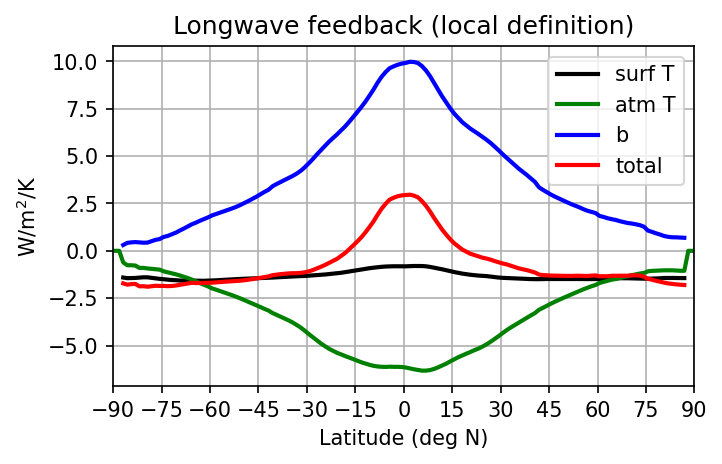

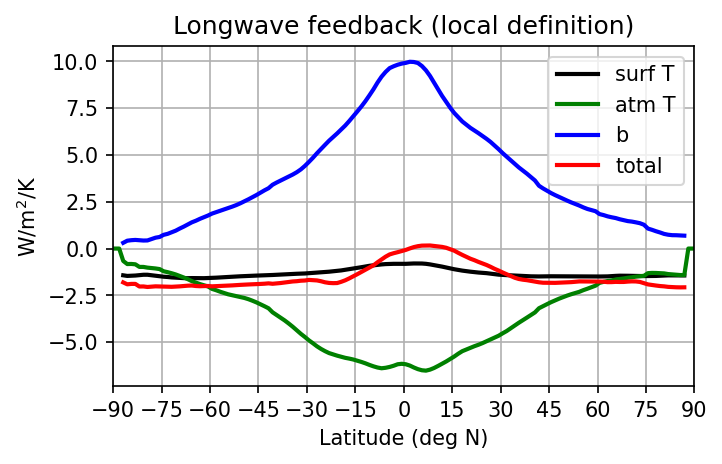

In [97]:
fig = plt.figure(figsize=(5,3),dpi=150)
LW_s_fb_1800.mean(('month','lon')).plot(lw=2,c='k',label='surf T')
(LW_atm_fb_1800.mean('month').mean('lon').sum('plev')).plot(lw=2,c='g',label='atm T')
wv_feedback.mean('month').plot(lw=2,c='b',label='b')
(t_feedback_1800 + wv_feedback_1800).plot(lw=2,c='r',label='total')
plt.grid()
plt.xticks(np.linspace(-90,90,13))
plt.xlim([-90,90])
plt.xlabel('Latitude (deg N)')
plt.ylabel('W/m$^2$/K')
plt.title('Longwave feedback (local definition)')
plt.legend()
plt.show()

fig = plt.figure(figsize=(5,3),dpi=150)
LW_s_fb_2700.mean(('month','lon')).plot(lw=2,c='k',label='surf T')
(LW_atm_fb_2700.mean('month').mean('lon').sum('plev')).plot(lw=2,c='g',label='atm T')
wv_feedback.mean('month').plot(lw=2,c='b',label='b')
(t_feedback_2700 + wv_feedback_2700).plot(lw=2,c='r',label='total')
plt.grid()
plt.xticks(np.linspace(-90,90,13))
plt.xlim([-90,90])
plt.xlabel('Latitude (deg N)')
plt.ylabel('W/m$^2$/K')
plt.title('Longwave feedback (local definition)')
plt.legend()
plt.show()

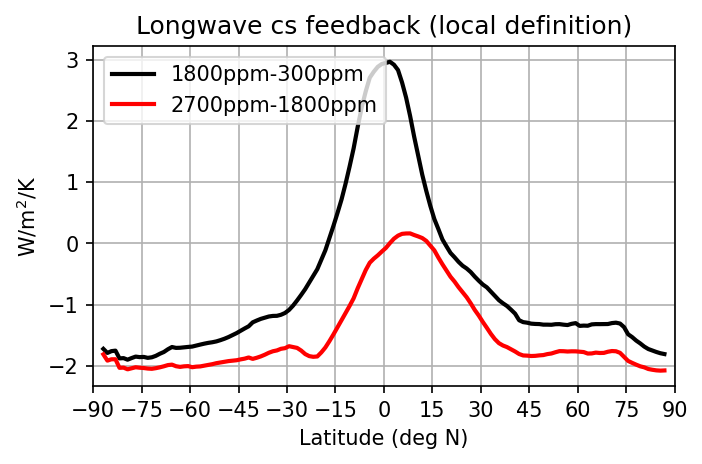

In [94]:
fig = plt.figure(figsize=(5,3),dpi=150)
(t_feedback_1800+wv_feedback_1800).plot(lw=2,c='k',label='1800ppm-300ppm')
(t_feedback_2700+wv_feedback_2700).plot(lw=2,c='r',label='2700ppm-1800ppm')
plt.grid()
plt.xticks(np.linspace(-90,90,13))
plt.xlim([-90,90])
plt.xlabel('Latitude (deg N)')
plt.ylabel('W/m$^2$/K')
plt.title('Longwave cs feedback (local definition)')
plt.legend()
plt.show()

In [95]:
print(diff_1800.soc_olr.mean(('lon','months')).weighted(weights).mean('lat').values)

-1.4280818377160882


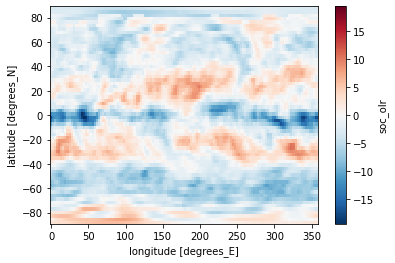

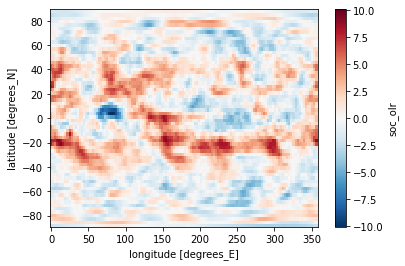

In [96]:
diff_1800.soc_olr.mean(('months')).plot()
plt.show()
diff_2700.soc_olr.mean(('months')).plot()
plt.show()